## Insurance Premium Challenge - Kaggle playground series - Regression

### Importing libraries and modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import optuna

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, root_mean_squared_error, make_scorer
from sklearn.ensemble import StackingRegressor

# Color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

### Setup
We load the data into a dataframe and take a first look at it.

In [3]:
df_train = pd.read_csv("train.csv", index_col="id")
df_test = pd.read_csv("test.csv", index_col="id")
df_train.head(5)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [4]:
# Make pandas recognize dates as dtype datetime64
df_train["Policy Start Date"] = pd.to_datetime(df_train['Policy Start Date'])
df_test["Policy Start Date"] = pd.to_datetime(df_test['Policy Start Date'])

In [5]:
df_train.describe().round(2)

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Premium Amount
count,1181295.00,1155051.00,1090328.00,1125924.00,835971.00,1199994.00,1062118.00,1199999.00,1200000,1200000.00
mean,41.15,32745.22,2.01,25.61,1.00,9.57,592.92,5.02,2022-02-13 05:06:30.972380672,1102.54
min,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,2019-08-17 15:21:39.080371,20.00
25%,30.00,8001.00,1.00,15.92,0.00,5.00,468.00,3.00,2020-11-20 15:21:39.121168896,514.00
50%,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,2022-02-14 15:21:39.151731968,872.00
75%,53.00,44634.00,3.00,34.53,2.00,15.00,721.00,7.00,2023-05-06 15:21:39.182597120,1509.00
max,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,2024-08-15 15:21:39.287115,4999.00
std,13.54,32179.51,1.42,12.20,0.98,5.78,149.98,2.59,NaN,865.00


### Understanding the data
#### Density plot of target variable "Premium Amount"

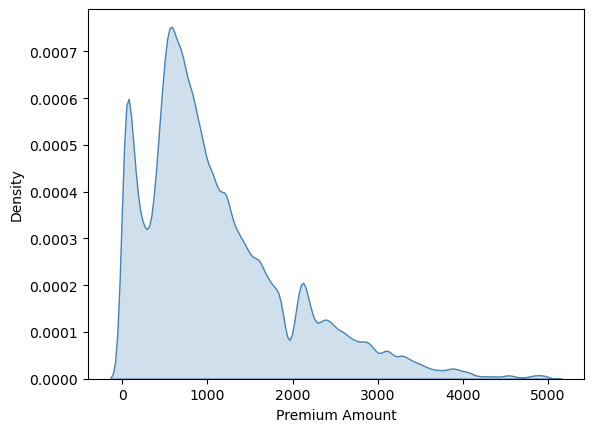

In [6]:
sns.kdeplot(data=df_train, x='Premium Amount', color='steelblue', fill=True);

#### Missing values
Some analysis on missing values in this section. Let us look first for how many values are missing in each column.

In [7]:
missing_val_summary = pd.DataFrame({'Missing Count': df_train.isnull().sum(), 'Missing Percentage': (df_train.isnull().sum() / df_train.shape[0]) * 100}).sort_values(by="Missing Count", ascending=False)
missing_val_summary

,Missing Count,Missing Percentage
Previous Claims,364029,30.335750
Occupation,358075,29.839583
Credit Score,137882,11.490167
Number of Dependents,109672,9.139333
Customer Feedback,77824,6.485333
Health Score,74076,6.173000
Annual Income,44949,3.745750
Age,18705,1.558750
Marital Status,18529,1.544083
Vehicle Age,6,0.000500


Useful way to visualize missing values using seaborn:

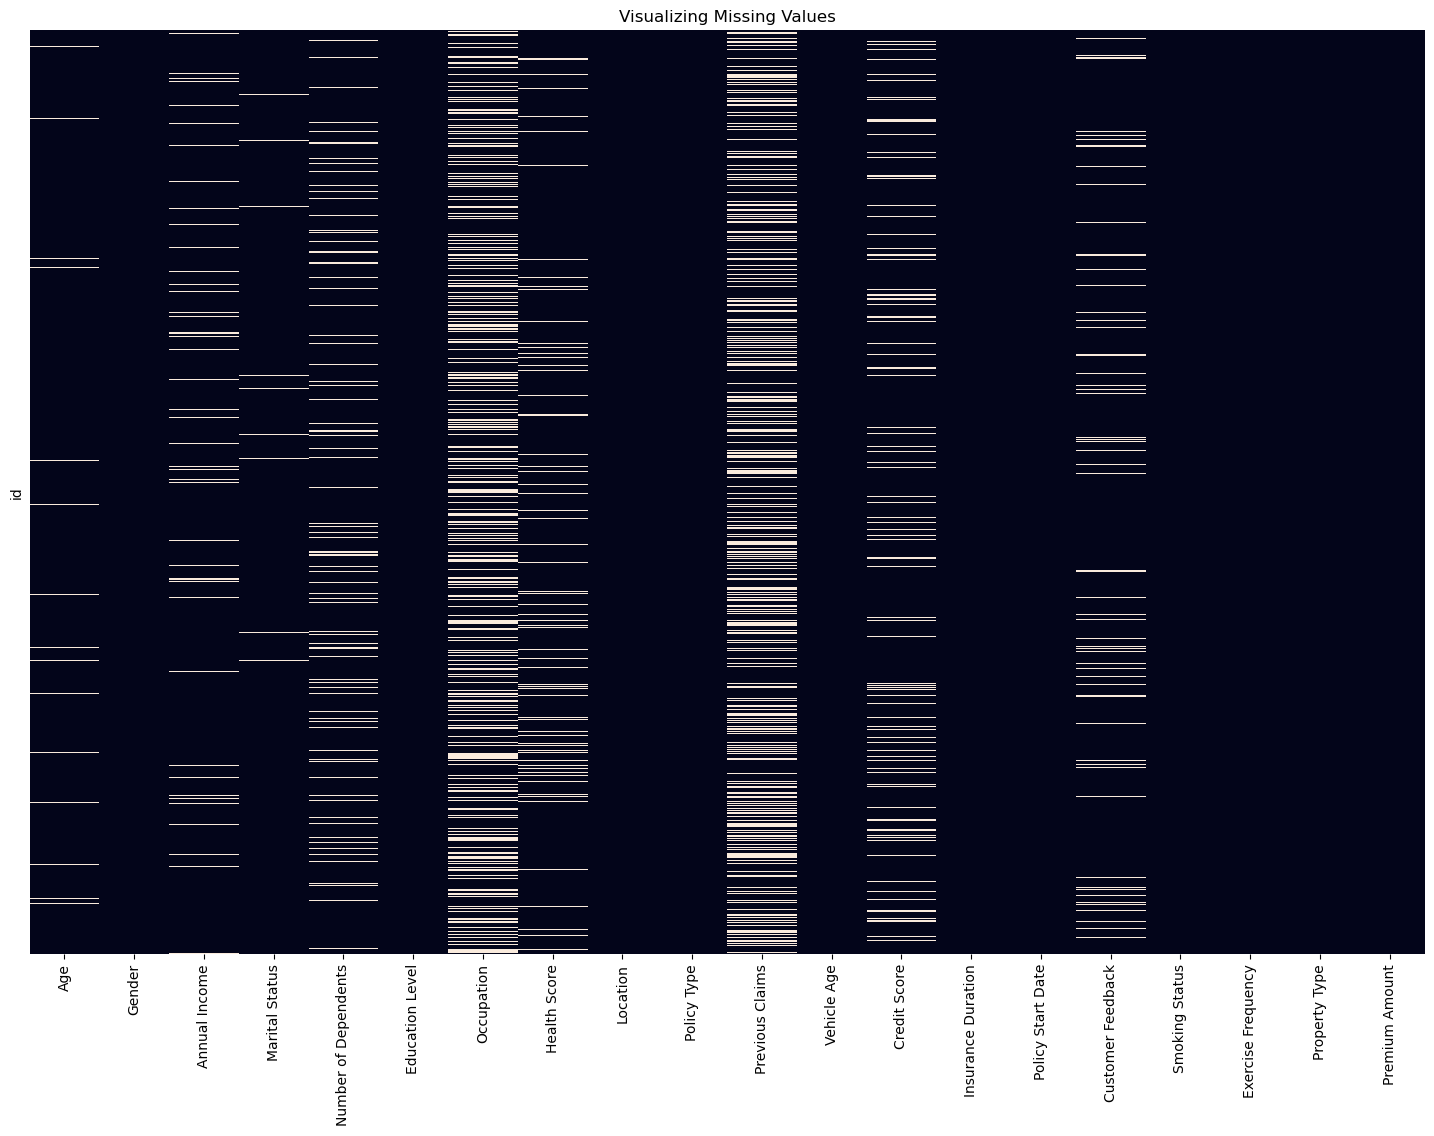

In [8]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False);

#### Categorical and numerical features

Next up, we look at the different types of features.

In [9]:
# Select categorical and numerical features
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop("Premium Amount")

# Print out column information
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())


Categorical Columns: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Numerical Columns: ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Policy Start Date']


How many unique values does each categorical column have?

In [10]:
for col in categorical_columns:
    num_unique = df_train[col].nunique()
    print(f"'{col}' has {num_unique} unique categories.")

'Gender' has 2 unique categories.
'Marital Status' has 3 unique categories.
'Education Level' has 4 unique categories.
'Occupation' has 3 unique categories.
'Location' has 3 unique categories.
'Policy Type' has 3 unique categories.
'Customer Feedback' has 3 unique categories.
'Smoking Status' has 2 unique categories.
'Exercise Frequency' has 4 unique categories.
'Property Type' has 3 unique categories.


Checking test data too for consistency:

In [11]:
for col in categorical_columns:
    num_unique = df_test[col].nunique()
    print(f"'{col}' has {num_unique} unique categories.")

'Gender' has 2 unique categories.
'Marital Status' has 3 unique categories.
'Education Level' has 4 unique categories.
'Occupation' has 3 unique categories.
'Location' has 3 unique categories.
'Policy Type' has 3 unique categories.
'Customer Feedback' has 3 unique categories.
'Smoking Status' has 2 unique categories.
'Exercise Frequency' has 4 unique categories.
'Property Type' has 3 unique categories.


We see that besides Policy Start Date, all other features have at most 4 unique categories, so we can deal with most of them by manual encoding. To get some idea of the relation with the Premium Amount, we can look at box plots. For example, have a look at the following two:

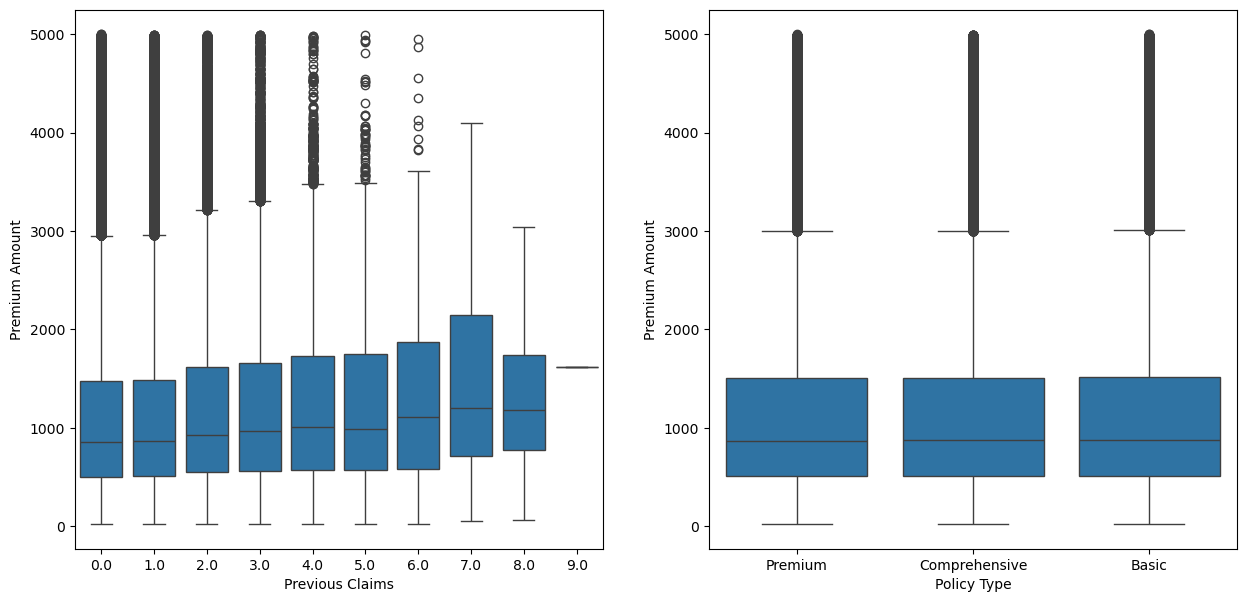

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

plt_1 = sns.boxplot(data=df_train, x='Previous Claims', y='Premium Amount', ax=ax[0])
plt_2 = sns.boxplot(data=df_train, x='Policy Type', y='Premium Amount', ax=ax[1]);

Not surprisingly, there seems to be a correlation between previous claims and the premium amount. Observe there is an outlier where $\text{Previous Claims} = 9$. 

For Policy Type, there seems to be no relation with the premium amount.

### Data preprocessing and feature engineering
Based on the above, we will prepare our data for the training process. We will also directly prepare the test data for prediction.

#### Dealing with dates
After inspection we note that the policy start date always is always the same hour, minute and second. Also, there are only 221 unique decimal places. Since this does not carry any information, we will only keep year, month and weekday.

In [13]:
# Extract features

date_column = "Policy Start Date"

for df in [df_train, df_test]:

    df['Year'] = df[date_column].dt.year
    df['Month'] = df[date_column].dt.month
    df['Weekday'] = df[date_column].dt.weekday
    df = df.drop(columns=[date_column])

df_train = df_train.drop(columns=[date_column])
df_test = df_test.drop(columns=[date_column])

#### Binary categorical features
The two categorical features "Gender" and "Smoking Status" are binary (i.e. only have two unique values), so we just use $0$-$1$-encoding.

In [14]:
for df in [df_train, df_test]: 
    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
    df["Smoking Status"] = df["Smoking Status"].map({"Yes": 1, "No": 0})

#### Other categorical features
For the remaining categorical features, we saw above that they all consist of three to four unique categories. Furthermore, the features carry some natural order (e.g. in some sense Bachelor's < Master's for degree, Basic < Comprehensive for policy type). We therefore encode them with integer values respecting this order.

In [15]:
for df in [df_train, df_test]:
     df['Marital Status'] = df['Marital Status'].map({"Married": 0, "Divorced": 1, "Single": 2})
     df['Education Level'] = df['Education Level'].map({"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3})
     df['Occupation'] =  df['Occupation'].map({"Unemployed": 0, "Employed": 1, "Self-Employed": 2})
     df['Location'] = df['Location'].map({"Rural": 0, "Suburban": 1, "Urban": 2})
     df['Policy Type'] = df['Policy Type'].map({"Basic": 0, "Comprehensive": 1, "Premium": 2})
     df['Customer Feedback'] = df['Customer Feedback'].map({"Poor": 0, "Average": 1, "Good": 2})
     df['Exercise Frequency'] = df['Exercise Frequency'].map({"Rarely": 0, "Monthly": 1, "Weekly": 2, "Daily": 3})
     df['Property Type'] = df['Property Type'].map({"Apartment": 0, "Condo": 1, "House": 2})
     df['Years since 2019'] = df['Year'] - 2019

#### Impute remaining NaNs?
As we can see, there are quite many missing values for some of the features. If we want to perform e.g. a linear regression, we need a way of filling in the missing values. Decision tree-based models like XGBoost and LightGBM can deal with missing values very well though, so we will keep them for now.

In [ ]:
"""
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())                       # Scale numerical features
])
"""

## Training the model
We will use the libraries XGBoost and LightGBM.

In [17]:
X_train = df_train.drop(columns=["Premium Amount"])
y_train = df_train["Premium Amount"]

# Converting the labels to the log1p scale
y_train_log = np.log1p(y_train)

X_test = df_test

In [18]:
# Modified RMSE scoring function

def rmse(y_true, y_pred_log):
    return root_mean_squared_error(y_true, np.maximum(y_pred_log, 0))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Tuning using Optuna
Optuna provides a useful algorithm for hyperparameter optimization. We start by defining an objective function which returns the cross-validation accuracy score of the model with the current set of hyperparameters. This is the function we will maximimze using Optuna.

In [24]:
# Objective function to be optimized by Optuna
def objective(trial, X, y, regressor="XGB"):
    
    if regressor == "LGB":
        
        params = {
            # Fix a learning rate
            'learning_rate': 0.05,
            
            # Tree Structure
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 20, 500),
            'min_child_samples': trial.suggest_int('min_child_samples', 100, 1000),
    
            # Number of trees
            'n_iterations': trial.suggest_int('n_iterations', 100, 300),
    
            # Further parameters
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),   # lambda in XGBoost
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),   # alpha in XGBoost
            'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0), # alias colsample_bytree
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.0, 1.0), # alias subsample
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
        }

        model = lgb.LGBMRegressor(**params, verbose=-1)


    else:

        params = {
            # Fix a learning rate
            'learning_rate': 0.05,

            # Number of trees
            'n_estimators': trial.suggest_int('n_estimators', 300, 1500),

            # Tree structure
            'max_depth': trial.suggest_int('max_depth', 3, 10),

            # Further parameters
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 4),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 4)
        }

        model = xgb.XGBRegressor(**params)

    # Converting the labels to the log1p scale
    y_log = np.log1p(y_train)
    
    # Compute the 4-fold cross-validation score
    cv_scores = cross_val_score(model, X, y_log, cv=4, scoring=rmse_scorer, verbose=1)

    # cross_val_score returns (-1) times the rmse because of the way we defined the rmse_scorer
    return -cv_scores.mean()

#### Objective function implementing early stopping 

In [20]:
# Objective function to be optimized by Optuna
def objective_early(trial, X, y, regressor="XGB"):
    
    if regressor == "LGB":
        
        params = {
            # Fix a learning rate
            'learning_rate': 0.05,
            
            # Tree Structure
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 20, 2000),
            'min_child_samples': trial.suggest_int('min_child_samples', 100, 1000),
    
            # Number of trees
            'n_iterations': 1000,
    
            # Further parameters
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),   # lambda in XGBoost
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),   # alpha in XGBoost
            'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0), # alias colsample_bytree
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.0, 1.0), # alias subsample
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
        }

        model = lgb.LGBMRegressor(**params, verbose=-1)

    else:

        params = {
            # Fix a learning rate
            'learning_rate': 0.05,
            
            # Number of trees
            'n_estimators': 1000,

            # Tree structure
            'max_depth': trial.suggest_int('max_depth', 3, 10),

            # Further parameters
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 4),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 4)
        }

        model = xgb.XGBRegressor(**params, early_stopping_rounds=50)

    # Converting the labels to the log1p scale
    y_log = np.log1p(y_train)
    
    # Compute the 4-fold cross-validation score
    kfold = KFold(n_splits=4)

    val_rmsle_scores = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train_split, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_split, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_train_log = np.log1p(y_train_split)
        y_val_log = np.log1p(y_val)
        
        if regressor == "LGB":
            model = lgb.LGBMRegressor(**params, verbose=-1)
            model.fit(X_train_split, y_train_log, callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)], eval_set=[(X_val, y_val_log)])
            
        elif regressor == "XGB":
            model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
            model.fit(X_train_split, y_train_log, eval_set=[(X_val, y_val_log)])
        
        y_val_log_pred = model.predict(X_val)
        y_val_pred = np.expm1(y_val_log_pred)

        val_rmsle = np.sqrt(mean_squared_log_error(y_val, y_val_pred))

        val_rmsle_scores.append(val_rmsle)


    # Return the mean accuracy
    return np.mean(val_rmsle_scores)

#### Tuning the LightGBM regressor
The optimization of the above objective function is done via an instance of the Study class in Optuna.

In [ ]:
study_lgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=42))
optuna.logging.set_verbosity(optuna.logging.WARNING)

# def log_best_trial(study, trial):
#     if study.best_trial == trial:
#         print(f"New best trial: {trial.number} with value: {trial.value} and params: {trial.params}")

func = lambda trial: objective(trial, X_train, y_train, regressor="LGB")
study_lgb.optimize(func, n_trials=50, show_progress_bar=True) # if needed: callbacks=[log_best_trial]

# Best hyperparameters
print("Best accuracy:", study_lgb.best_value)
print("Best parameters:", study_lgb.best_params)

#### Tuning the XGBoost regressor

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=42))
optuna.logging.set_verbosity(optuna.logging.WARNING)

# def log_best_trial(study, trial):
#    if study.best_trial == trial:
#        print(f"New best trial: {trial.number} with value: {trial.value} and params: {trial.params}")

func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=50, show_progress_bar=True) # if needed: callbacks=[log_best_trial]

# Best hyperparameters
print("Best accuracy:", study.best_value)
print("Best parameters:", study.best_params)

### Final training and test set predictions
Finally, we train the model on the full training dataset using a stacked classifier consisting of the XGBoost and LightGBM classifiers with the best hyperparamaters. We ran the above optuna studies a few times with different parameter ranges and arrived at the parameters below.

In [26]:
# Best hyperparameters

lgb_params = {'max_depth': 8, 'learning_rate': 0.05, 'n_iterations': 800, 'num_leaves': 386, 'min_child_samples': 973, 'lambda_l1': 1.2604664585649463, 'lambda_l2': 5.727904470799624, 'feature_fraction': 0.8948273504276488, 'bagging_fraction': 0.5978999788110851, 'bagging_freq': 7}

xgb_params ={'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 7, 'subsample': 0.6554563366576581, 'colsample_bytree': 0.8756677022116469}

In [34]:
# Fitting an XGB and a LGBM regressor, each with the best parameters

xgb_model = xgb.XGBRegressor(**xgb_params)
lgb_model = lgb.LGBMRegressor(**lgb_params, verbose=-1)

xgb_model.fit(X_train, y_train_log)
lgb_model.fit(X_train, y_train_log)

# Make predictions and convert back from log scale

y_test_log_xgb = xgb_model.predict(X_test)
y_test_xgb = np.expm1(y_test_log_xgb)

y_test_log_lgb = lgb_model.predict(X_test)
y_test_lgb = np.expm1(y_test_log_lgb)

#### Stacking Regressor
Finally, we build a stacking regressor, which combines the XGB and LGBM models to obtain a (hopefully) even more powerful predictor.

In [31]:
# Fit a stacking regressor consisting of the two best XGB and LGBM models we found

xgb_model = xgb.XGBRegressor(**xgb_params)
lgb_model = lgb.LGBMRegressor(**lgb_params, verbose=-1)

stacking_model = StackingRegressor(
    estimators = [
        ("xgb", xgb_model),
        ("lgb", lgb_model)
    ]
)

stacking_model.fit(X_train, y_train_log)

y_test_log = stacking_model.predict(X_test)
y_test = np.expm1(y_test_log)

It remains to save the made predictions in a csv file:

In [32]:
sample = pd.read_csv("sample_submission.csv")

sample["Premium Amount"] = y_test_xgb
sample.to_csv("submission_xgb.csv", index=False)

sample["Premium Amount"] = y_test_lgb
sample.to_csv("submission_lgb.csv", index=False)

sample["Premium Amount"] = y_test
sample.to_csv("submission_stacking.csv", index=False)

The XGB, LGBM and stacking regressor predictions got us test scores on the kaggle leaderboard of $1.04615, 1.04565, 1.04504$, respectively.

The XGB, LGBM and stacking regressor predictions got us test scores on the kaggle test set of $1.04615, 1.04565, 1.04504$, respectively, the last score securing position 82/575 on the leaderboard by 12:24 CET on Dec 6, 2024. It seems to be the case that scores can be significantly improved by training models minimizing the RMSE instead of the RMSLE and then use the RMSE values as a feature for the training of the models minimizing RMSLE.

### Inference / parameter importance
Let us finally look at which features are the most important in predicting the Premium Amount. We start by looking at the feature importance plots corresponding to the best LGBM and XGB models.

#### XGB feature importance plot

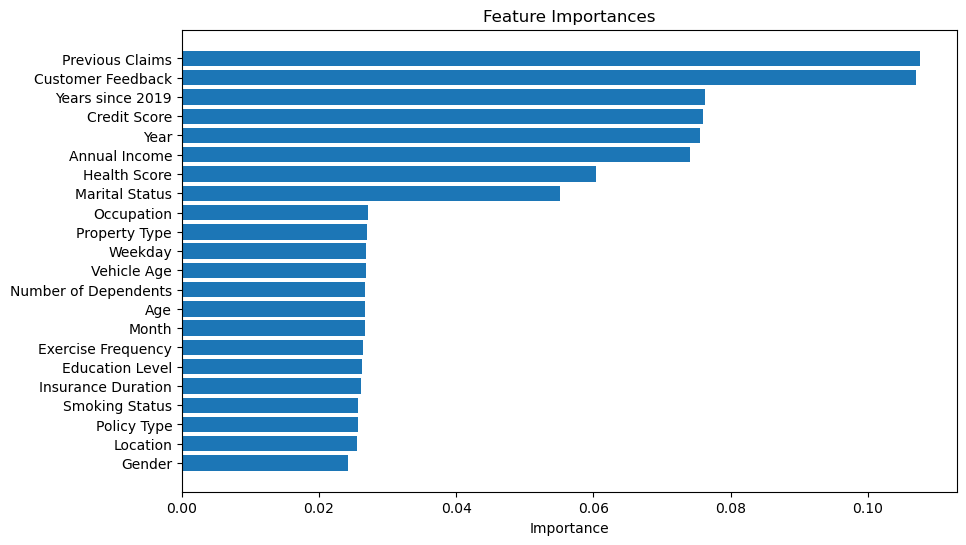

In [35]:
# Note: this requires to fit the XGB model again after fitting the stacking regressor

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

#### LGBM feature importance plot

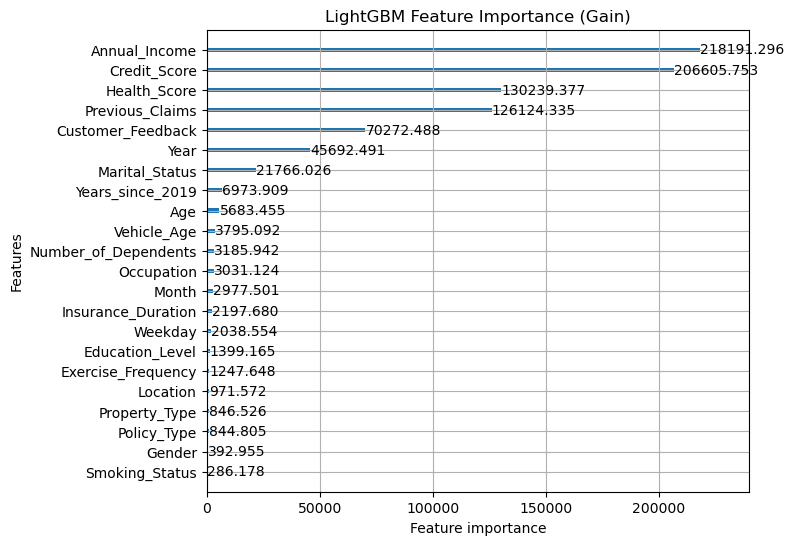

In [36]:
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Both plots suggest similar feature importances.